In [3]:
suppressMessages(library("SpatialExperiment"))
suppressMessages(library("SingleCellExperiment"))
suppressMessages(library("DropletUtils"))
suppressMessages(library("Seurat"))
suppressMessages(library("ggspavis"))
suppressMessages(library("scater"))
suppressMessages(library("ggplot2"))
suppressMessages(library("patchwork"))
suppressMessages(library("biomaRt"))
suppressMessages(library("nnSVG"))
suppressMessages(library("scran"))
suppressMessages(library("igraph"))
suppressMessages(library("pheatmap"))
suppressMessages(library("msigdbr"))
suppressMessages(library("AUCell"))
suppressMessages(library("BiocParallel"))

bp <- MulticoreParam(th <- 10)


Warning message:
“package ‘DropletUtils’ was built under R version 4.4.3”
Warning message:
“package ‘SeuratObject’ was built under R version 4.4.3”
Warning message:
“package ‘msigdbr’ was built under R version 4.4.3”


In [ ]:
GSM6171788_PSAPP_CO2
GSM6171792_PSAPP_CO3

GSM6171785_PSAPP_TAM1
GSM6171789_PSAPP_TAM2
GSM6171793_PSAPP_TAM3

### PSAPP CO1

In [80]:
spe <- readRDS("../data/ST_GSM6171784_PSAPP_CO1.rds")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


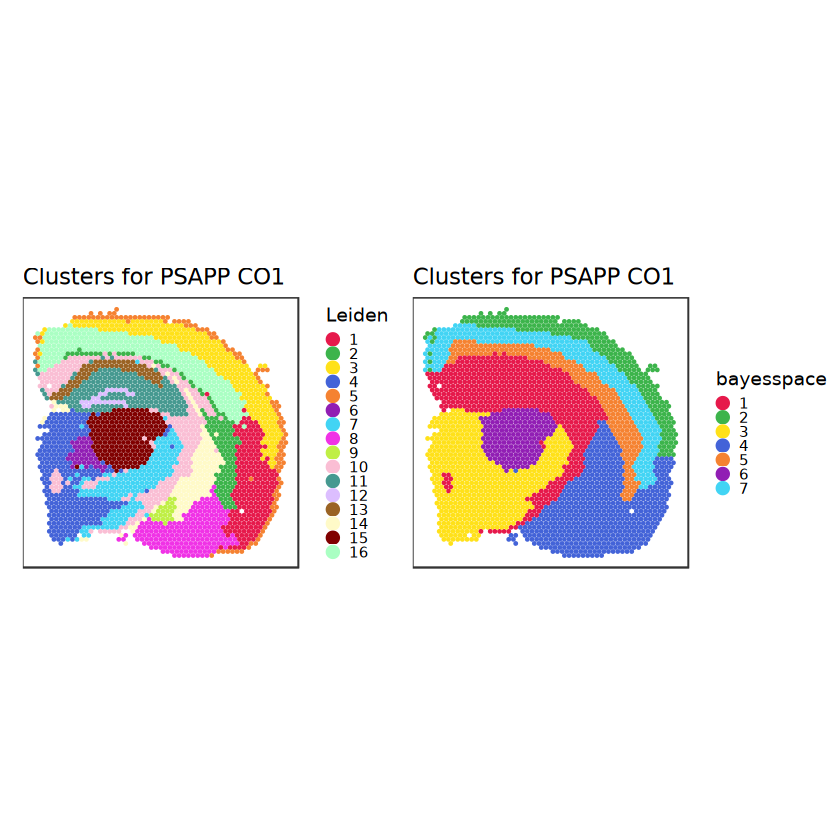

In [81]:
plotSpots(spe, annotate="Leiden") +
plotSpots(spe, annotate="bayesspace") +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Clusters for PSAPP CO1")

In [82]:
# find marker genes 
mgs <- findMarkers(spe, groups=spe$bayesspace, direction="up")
top <- lapply(mgs, \(df) rownames(df)[df$Top <= 3])
length(top <- unique(unlist(top)))

[1] 68

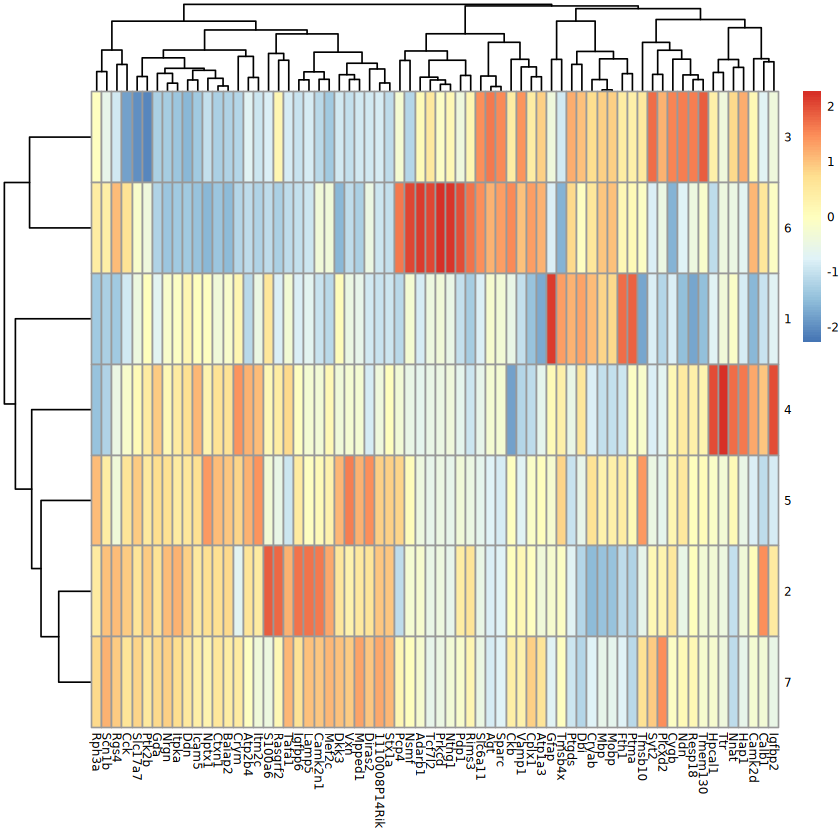

In [83]:
# plot heatmap of top marker genes per cluster
pbs <- aggregateAcrossCells(spe,  
    ids=spe$bayesspace, subset.row=top, 
    use.assay.type="logcounts", statistics="mean")
# use symbols as feature names
mtx <- t(assay(pbs))
colnames(mtx) <- rowData(pbs)$symbol
pheatmap(mat=mtx, scale="column", fontsize = 7)

In [8]:
# save mtx as csv
write.csv(mtx, file="../data/marker_genes_CO1.csv", row.names=TRUE)

#### Annotation 

In [84]:
# assign cell types to clusters
spe$celltype <- NA
spe$celltype[spe$bayesspace == "1"] <- "Oligodendrocytes"                
spe$celltype[spe$bayesspace == "2"] <- "Excitatory Neurons (glutamatergic)"               
spe$celltype[spe$bayesspace == "3"] <- "Astrocytes"
spe$celltype[spe$bayesspace == "4"] <- "Inhibitory Neurons"                   
spe$celltype[spe$bayesspace == "5"] <- "Excitatory Neurons" 
spe$celltype[spe$bayesspace == "6"] <- "Astrocytes/Reactive Astrocytes"                 
spe$celltype[spe$bayesspace == "7"] <- "Excitatory Neurons" 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


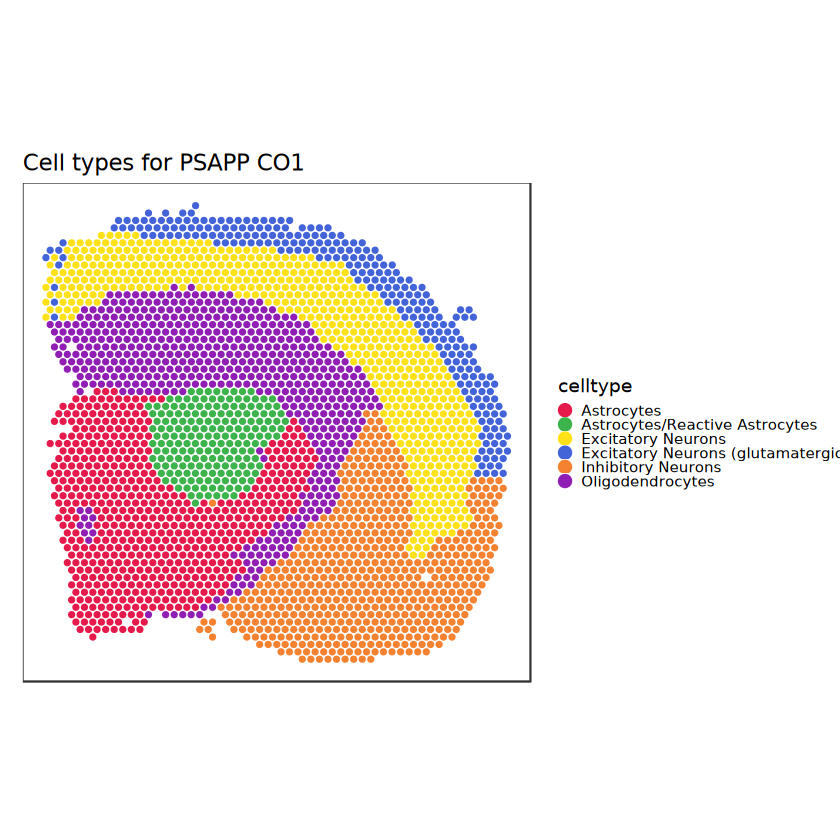

In [85]:
plot_cell_type <- plotSpots(spe, annotate="celltype", point_size=1) +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Cell types for PSAPP CO1")
plot_cell_type
ggsave("cell_types_plot_PSAPP_CO1.png", plot=plot_cell_type, width=10, height=8, dpi=300)

#### Signatures

In [86]:
# retrieve hallmark gene sets from 'MSigDB'
db <- msigdbr(species="Mus musculus", collection="H")
# get list of gene symbols, one element per set
gs <- split(db$ensembl_gene, db$gs_name)
# simplify set identifiers (drop prefix, use lower case)
names(gs) <- tolower(gsub("HALLMARK_", "", names(gs)))
# how many sets?
length(gs)

[1] 50

In [87]:
# run AUCell for signature scoring

# realize (sparse) gene expression matrix
mtx <- as(logcounts(spe), "dgCMatrix") 
# use ensembl identifiers as feature names
rownames(mtx) <- rowData(spe)$ensembl_id
# build per-spot gene rankings
rnk <- AUCell_buildRankings(mtx, BPPARAM=bp, plotStats=FALSE, verbose=FALSE)
# calculate AUC for each gene set in each spot
auc <- AUCell_calcAUC(geneSets=gs, rankings=rnk, nCores=th, verbose=FALSE)
# add results as spot metadata
colData(spe)[rownames(auc)] <- res <- t(assay(auc)) 

In [88]:
# take top sets
var <- colVars(res)
top <- names(tail(sort(var), 8))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


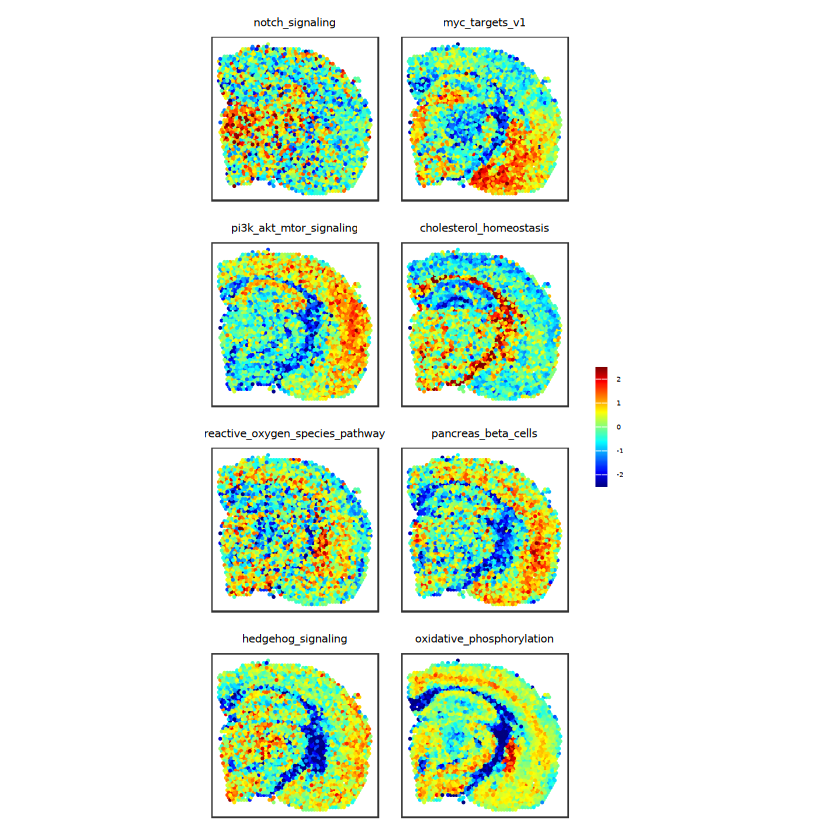

In [89]:
p <- lapply(top, \(.) {
    spe[[.]] <- scale(spe[[.]]) # scaling
    plotSpots(spe, annotate=., point_size = 0.05) # plotting
}) |> 
    # arrange & prettify
    wrap_plots(ncol=2, guides="collect") & 
    scale_color_gradientn(
        colors=pals::jet(),
        oob=scales::squish, 
        limits=c(-2.5, 2.5)) & 
    theme(
        text = element_text(size = 5),
        legend.key.width=unit(0.5, "lines"), 
        legend.key.height=unit(1, "lines")) 
p
ggsave("signature_analysis_plot_PSAPP_CO1.png", plot=p, width=10, height=8, dpi=300)

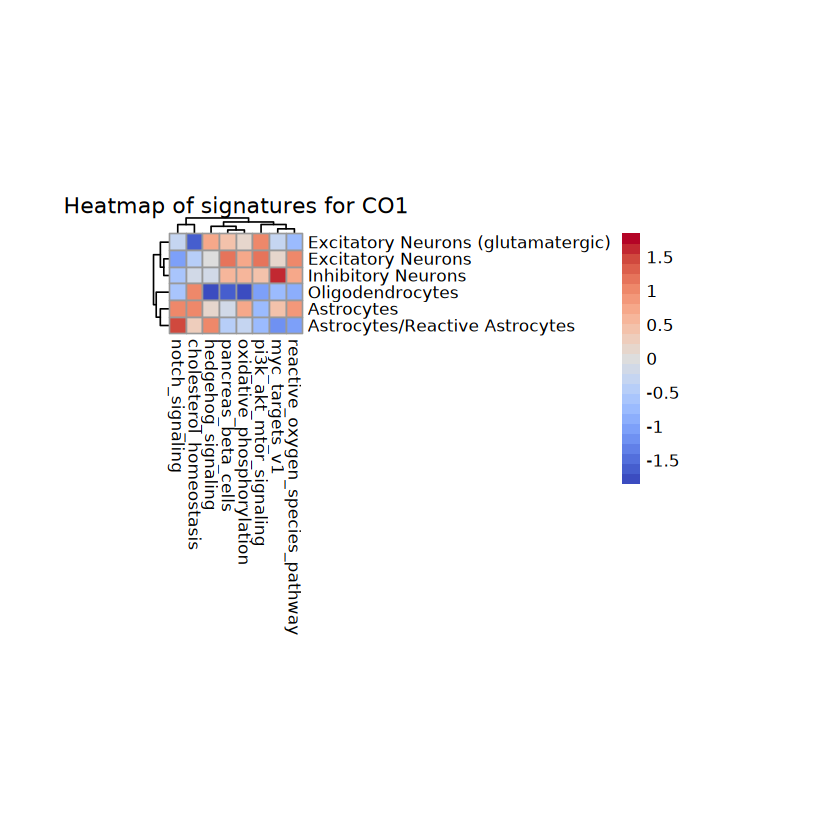

In [90]:
for (. in c("celltype")) {
    # aggregate AUC values by cluster
    mu <- aggregateAcrossCells(auc[top, ], spe[[.]], 
        use.assay.type="AUC", statistics="mean")
    # visualize as (cluster x set) heatmap
    pheatmap(
        mat=t(assay(mu)), scale="column", col=pals::coolwarm(), 
        main=paste("Heatmap of signatures for CO1"),
        cellwidth=10, cellheight=10, treeheight_row=5, treeheight_col=5)
}

### PSAPP CO2

In [91]:
spe <- readRDS("../data/ST_GSM6171788_PSAPP_CO2.rds")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


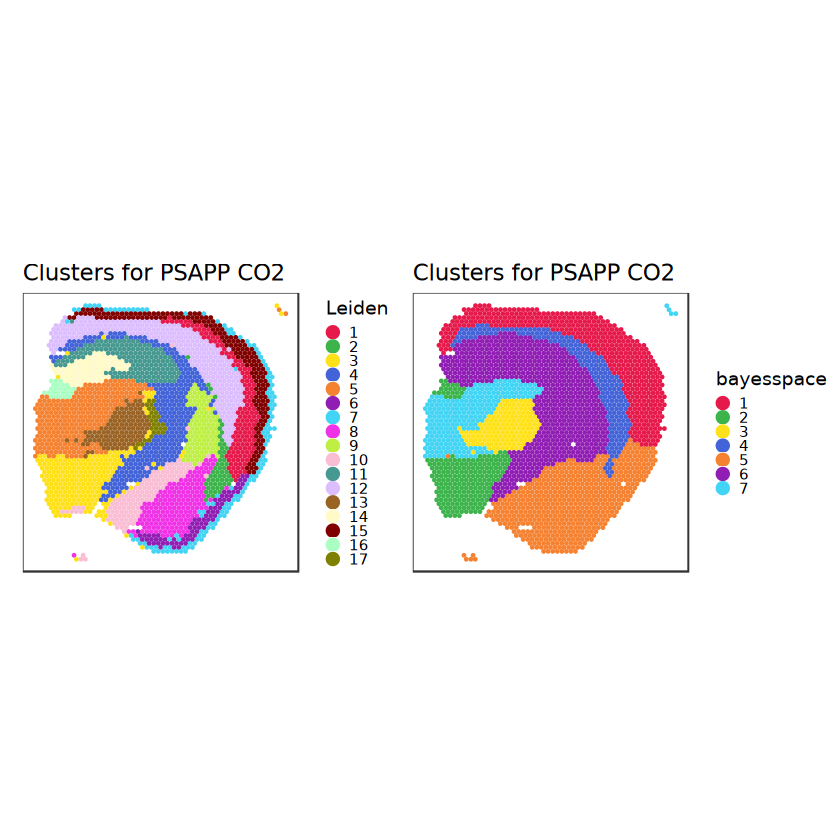

In [92]:
plotSpots(spe, annotate="Leiden") +
plotSpots(spe, annotate="bayesspace") +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Clusters for PSAPP CO2")

In [93]:
# find marker genes 
mgs <- findMarkers(spe, groups=spe$bayesspace, direction="up")
top <- lapply(mgs, \(df) rownames(df)[df$Top <= 3])
length(top <- unique(unlist(top)))

[1] 68

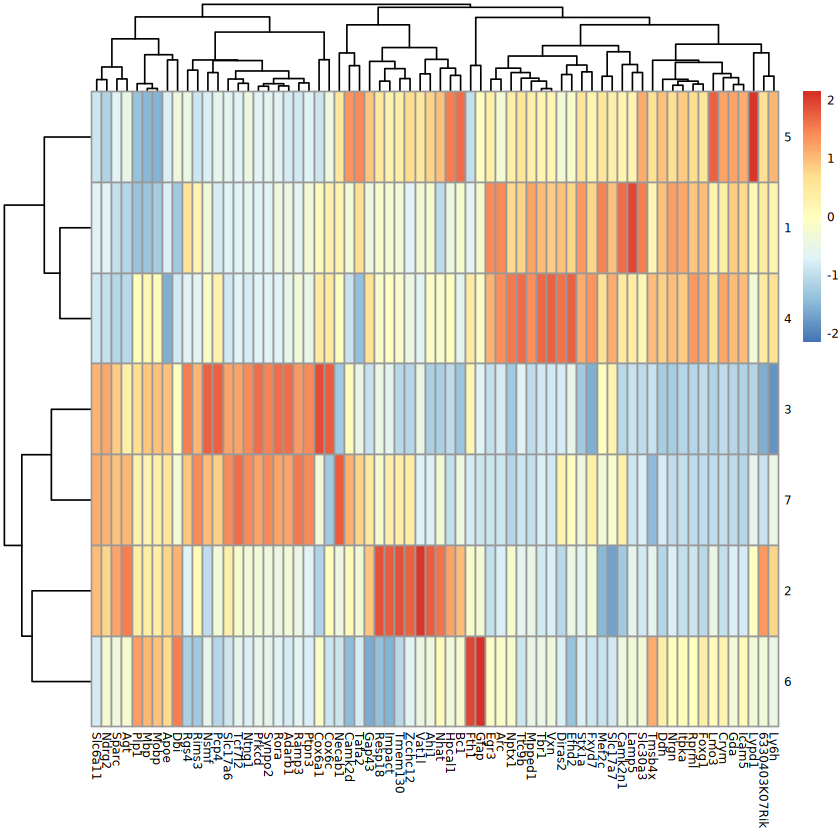

In [94]:
# plot heatmap of top marker genes per cluster
pbs <- aggregateAcrossCells(spe,  
    ids=spe$bayesspace, subset.row=top, 
    use.assay.type="logcounts", statistics="mean")
# use symbols as feature names
mtx <- t(assay(pbs))
colnames(mtx) <- rowData(pbs)$symbol
pheatmap(mat=mtx, scale="column", fontsize = 7)

In [32]:
# save mtx as csv
write.csv(mtx, file="../data/top_genes_CO2.csv", row.names=TRUE)

#### Annotation 

In [95]:
# assign cell types to clusters
spe$celltype <- NA
spe$celltype[spe$bayesspace == "1"] <- "Excitatory Neurons"                
spe$celltype[spe$bayesspace == "2"] <- "Astrocytes"               
spe$celltype[spe$bayesspace == "3"] <- "Inhibitory Neurons"
spe$celltype[spe$bayesspace == "4"] <- "Excitatory Neurons"                   
spe$celltype[spe$bayesspace == "5"] <- "Dentate gyrus granule cells" 
spe$celltype[spe$bayesspace == "6"] <- "Oligodendrocytes"                 
spe$celltype[spe$bayesspace == "7"] <- "Inhibitory Neurons" 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


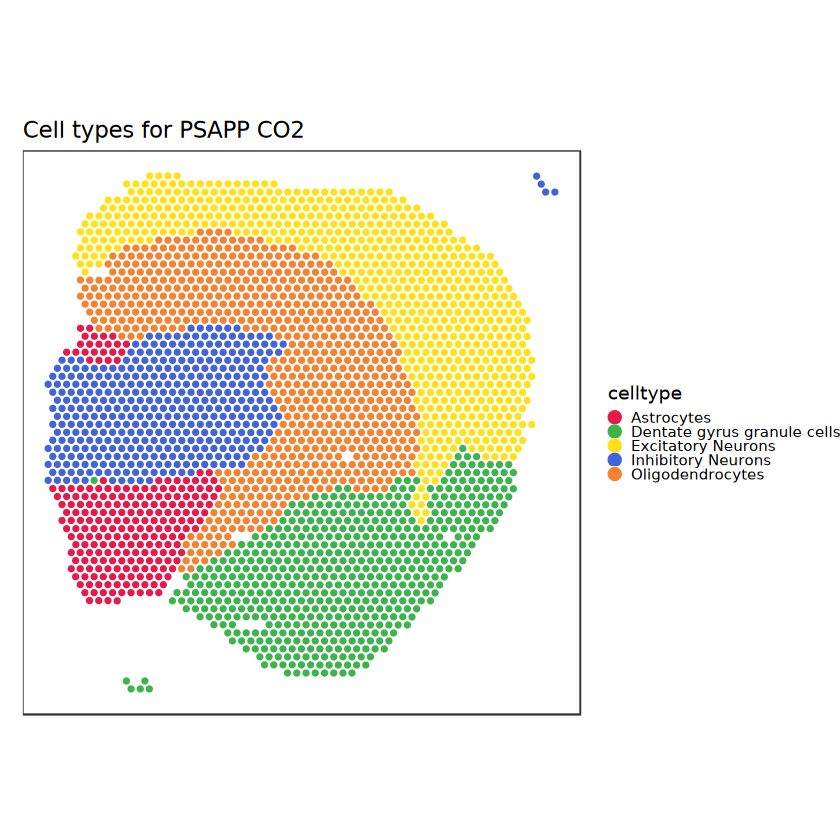

In [96]:
plot_cell_type <- plotSpots(spe, annotate="celltype", point_size=1) +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Cell types for PSAPP CO2")
plot_cell_type
ggsave("cell_types_plot_PSAPP_CO2.png", plot=plot_cell_type, width=10, height=8, dpi=300)

#### Signatures

In [35]:
# retrieve hallmark gene sets from 'MSigDB'
db <- msigdbr(species="Mus musculus", collection="H")
# get list of gene symbols, one element per set
gs <- split(db$ensembl_gene, db$gs_name)
# simplify set identifiers (drop prefix, use lower case)
names(gs) <- tolower(gsub("HALLMARK_", "", names(gs)))
# how many sets?
length(gs)

[1] 50

In [97]:
# run AUCell for signature scoring

# realize (sparse) gene expression matrix
mtx <- as(logcounts(spe), "dgCMatrix") 
# use ensembl identifiers as feature names
rownames(mtx) <- rowData(spe)$ensembl_id
# build per-spot gene rankings
rnk <- AUCell_buildRankings(mtx, BPPARAM=bp, plotStats=FALSE, verbose=FALSE)
# calculate AUC for each gene set in each spot
auc <- AUCell_calcAUC(geneSets=gs, rankings=rnk, nCores=th, verbose=FALSE)
# add results as spot metadata
colData(spe)[rownames(auc)] <- res <- t(assay(auc)) 

In [98]:
# take top sets
var <- colVars(res)
top <- names(tail(sort(var), 8))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


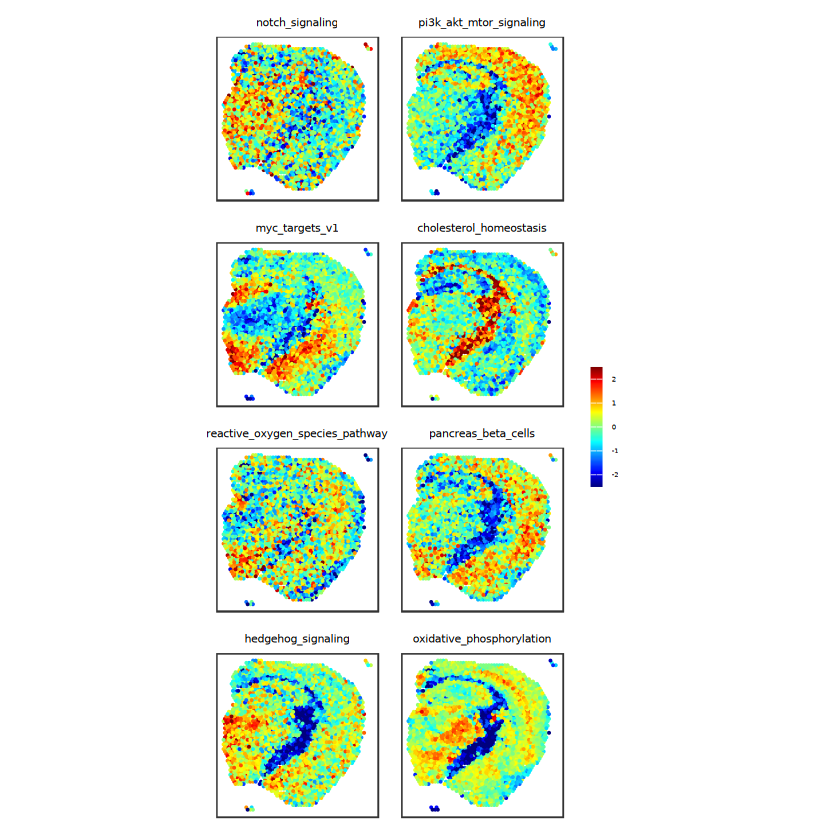

In [99]:
p <- lapply(top, \(.) {
    spe[[.]] <- scale(spe[[.]]) # scaling
    plotSpots(spe, annotate=., point_size = 0.05) # plotting
}) |> 
    # arrange & prettify
    wrap_plots(ncol=2, guides="collect") & 
    scale_color_gradientn(
        colors=pals::jet(),
        oob=scales::squish, 
        limits=c(-2.5, 2.5)) & 
    theme(
        text = element_text(size = 5),
        legend.key.width=unit(0.5, "lines"), 
        legend.key.height=unit(1, "lines")) 
p
ggsave("signature_analysis_plot_PSAPP_CO2.png", plot=p, width=10, height=8, dpi=300)

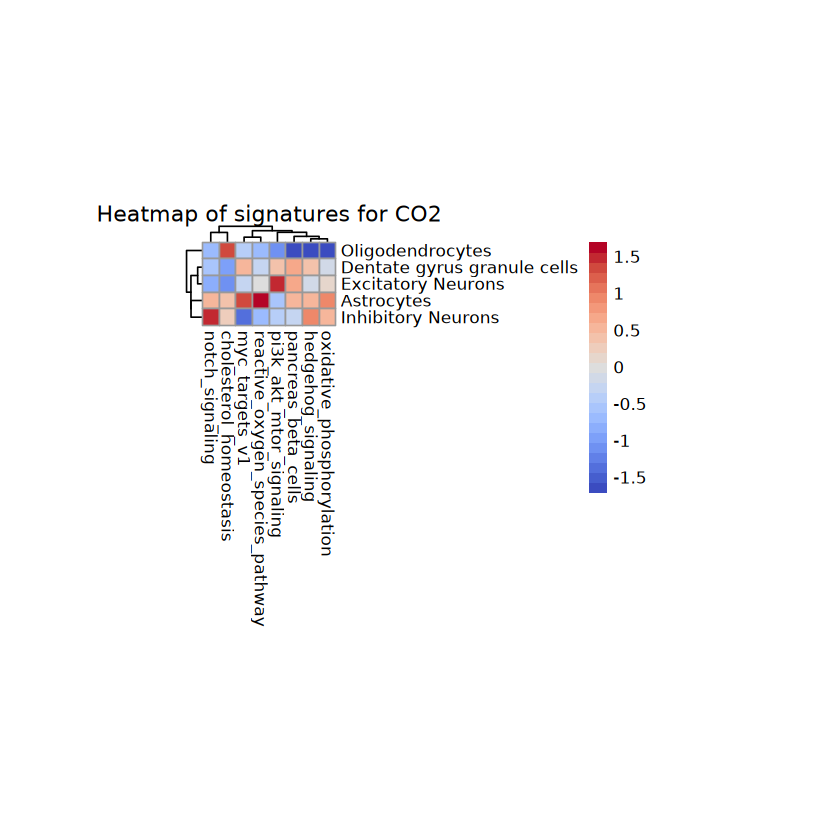

In [100]:
for (. in c("celltype")) {
    # aggregate AUC values by cluster
    mu <- aggregateAcrossCells(auc[top, ], spe[[.]], 
        use.assay.type="AUC", statistics="mean")
    # visualize as (cluster x set) heatmap
    pheatmap(
        mat=t(assay(mu)), scale="column", col=pals::coolwarm(), 
        main=paste("Heatmap of signatures for CO2"),
        cellwidth=10, cellheight=10, treeheight_row=5, treeheight_col=5)
}

### PSAPP CO3

In [101]:
spe <- readRDS("../data/ST_GSM6171792_PSAPP_CO3.rds")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


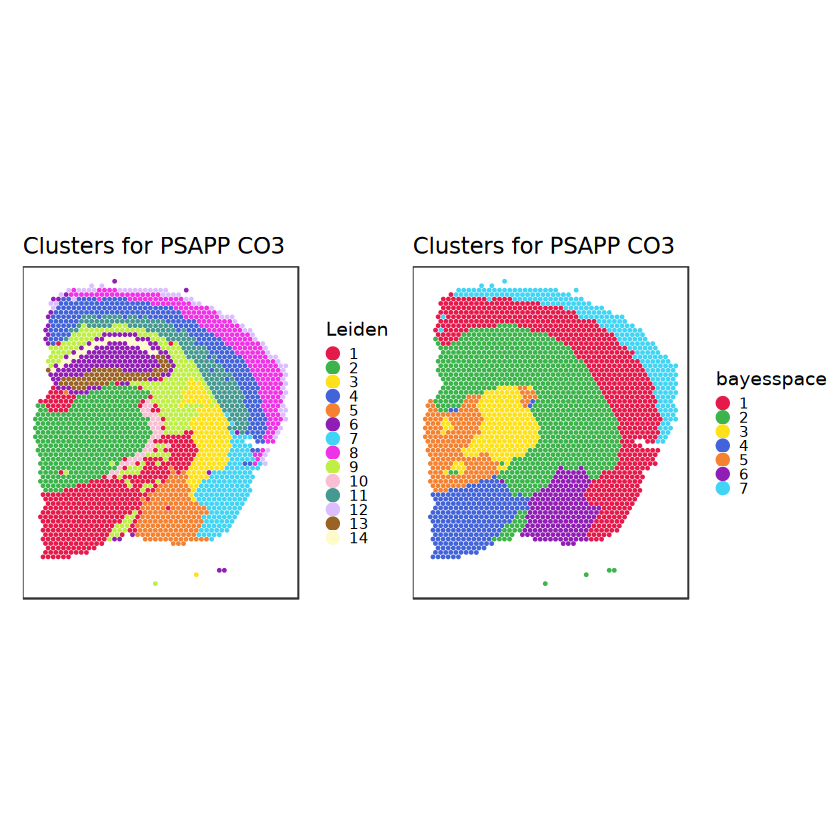

In [102]:
plotSpots(spe, annotate="Leiden") +
plotSpots(spe, annotate="bayesspace") +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Clusters for PSAPP CO3")

In [103]:
# find marker genes 
mgs <- findMarkers(spe, groups=spe$bayesspace, direction="up")
top <- lapply(mgs, \(df) rownames(df)[df$Top <= 3])
length(top <- unique(unlist(top)))

[1] 62

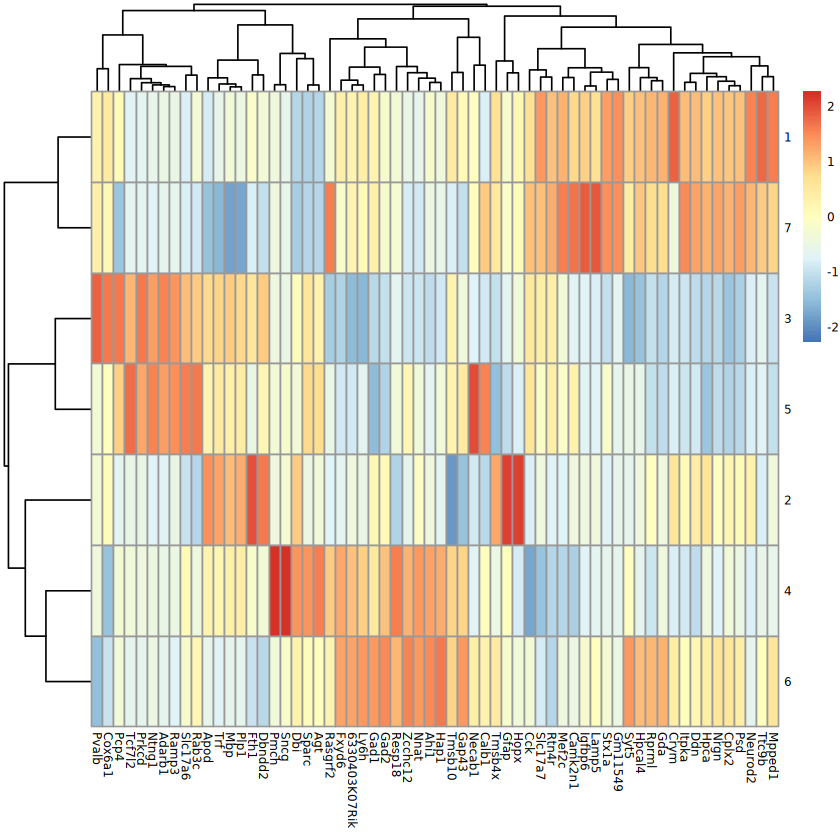

In [104]:
# plot heatmap of top marker genes per cluster
pbs <- aggregateAcrossCells(spe,  
    ids=spe$bayesspace, subset.row=top, 
    use.assay.type="logcounts", statistics="mean")
# use symbols as feature names
mtx <- t(assay(pbs))
colnames(mtx) <- rowData(pbs)$symbol
pheatmap(mat=mtx, scale="column", fontsize = 7)

In [43]:
# save mtx as csv
write.csv(mtx, file="../data/top_genes_CO3.csv", row.names=TRUE)

#### Annotation 

In [105]:
# assign cell types to clusters
spe$celltype <- NA
spe$celltype[spe$bayesspace == "1"] <- "Excitatory Neurons"                
spe$celltype[spe$bayesspace == "2"] <- "Oligodendrocytes"               
spe$celltype[spe$bayesspace == "3"] <- "Inhibitory Neurons"
spe$celltype[spe$bayesspace == "4"] <- "Astrocytes"                   
spe$celltype[spe$bayesspace == "5"] <- "Inhibitory Neurons" 
spe$celltype[spe$bayesspace == "6"] <- "Mixed neuronal population/Neuronal precursors"                 
spe$celltype[spe$bayesspace == "7"] <- "Excitatory Neurons" 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


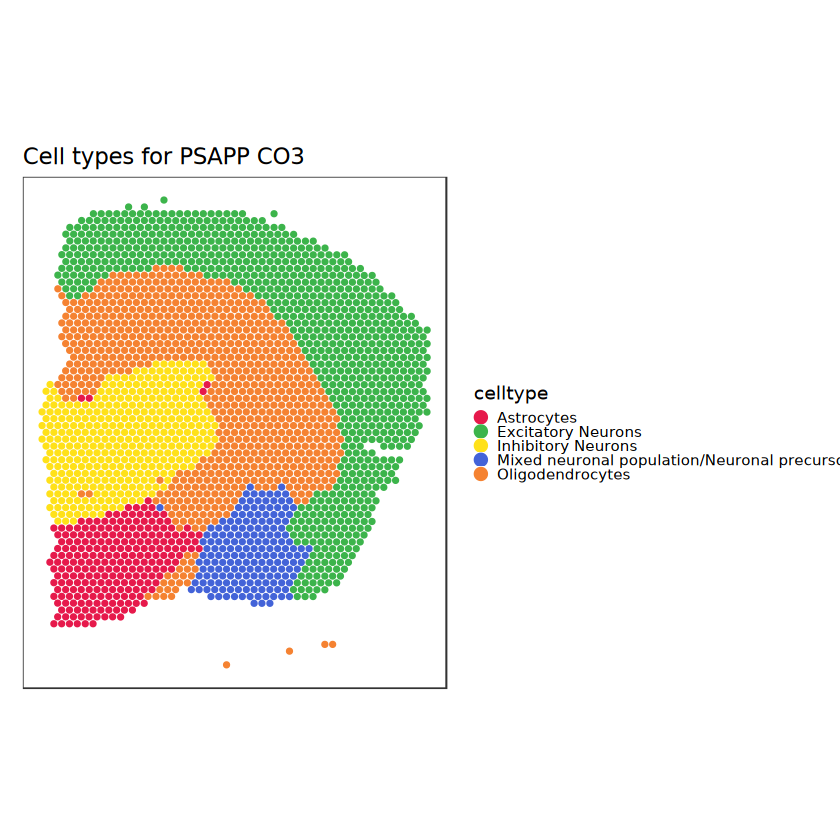

In [106]:
plot_cell_type <- plotSpots(spe, annotate="celltype", point_size=1) +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Cell types for PSAPP CO3")
plot_cell_type
ggsave("cell_types_plot_PSAPP_CO3.png", plot=plot_cell_type, width=10, height=8, dpi=300)

#### Signatures

In [ ]:
# retrieve hallmark gene sets from 'MSigDB'
db <- msigdbr(species="Mus musculus", collection="H")
# get list of gene symbols, one element per set
gs <- split(db$ensembl_gene, db$gs_name)
# simplify set identifiers (drop prefix, use lower case)
names(gs) <- tolower(gsub("HALLMARK_", "", names(gs)))
# how many sets?
length(gs)

[1] 50

In [107]:
# run AUCell for signature scoring

# realize (sparse) gene expression matrix
mtx <- as(logcounts(spe), "dgCMatrix") 
# use ensembl identifiers as feature names
rownames(mtx) <- rowData(spe)$ensembl_id
# build per-spot gene rankings
rnk <- AUCell_buildRankings(mtx, BPPARAM=bp, plotStats=FALSE, verbose=FALSE)
# calculate AUC for each gene set in each spot
auc <- AUCell_calcAUC(geneSets=gs, rankings=rnk, nCores=th, verbose=FALSE)
# add results as spot metadata
colData(spe)[rownames(auc)] <- res <- t(assay(auc)) 

In [108]:
# take top sets
var <- colVars(res)
top <- names(tail(sort(var), 8))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


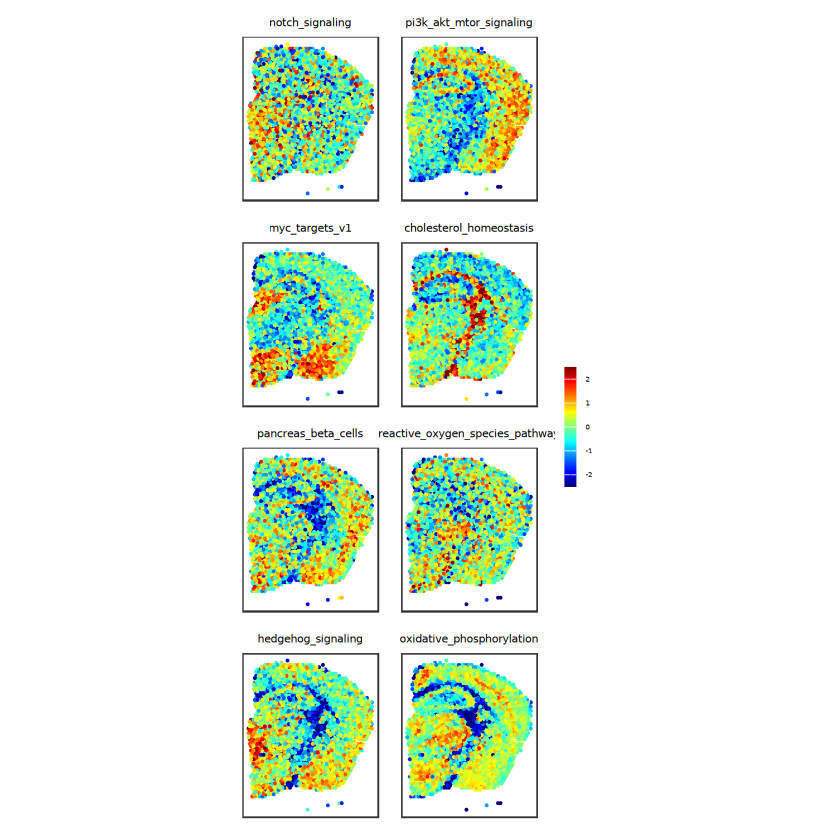

In [109]:
p <- lapply(top, \(.) {
    spe[[.]] <- scale(spe[[.]]) # scaling
    plotSpots(spe, annotate=., point_size = 0.05) # plotting
}) |> 
    # arrange & prettify
    wrap_plots(ncol=2, guides="collect") & 
    scale_color_gradientn(
        colors=pals::jet(),
        oob=scales::squish, 
        limits=c(-2.5, 2.5)) & 
    theme(
        text = element_text(size = 5),
        legend.key.width=unit(0.5, "lines"), 
        legend.key.height=unit(1, "lines")) 
p
ggsave("signature_analysis_plot_PSAPP_CO3.png", plot=p, width=10, height=8, dpi=300)

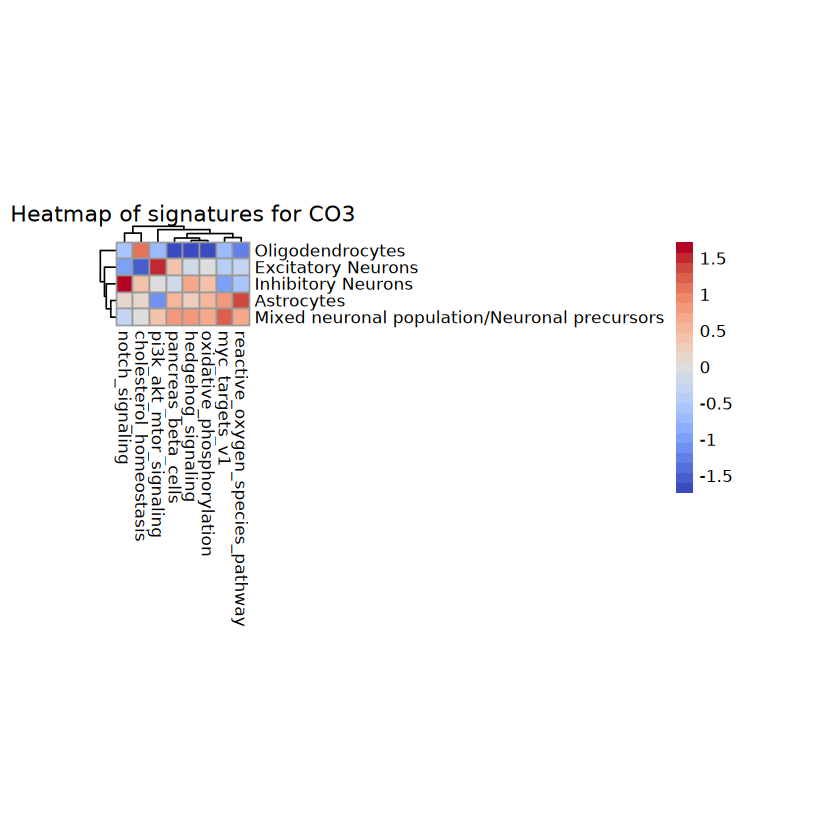

In [110]:
for (. in c("celltype")) {
    # aggregate AUC values by cluster
    mu <- aggregateAcrossCells(auc[top, ], spe[[.]], 
        use.assay.type="AUC", statistics="mean")
    # visualize as (cluster x set) heatmap
    pheatmap(
        mat=t(assay(mu)), scale="column", col=pals::coolwarm(), 
        main=paste("Heatmap of signatures for CO3"),
        cellwidth=10, cellheight=10, treeheight_row=5, treeheight_col=5)
}

### PSAPP TAM1

In [111]:
spe <- readRDS("../data/ST_GSM6171785_PSAPP_TAM1.rds")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


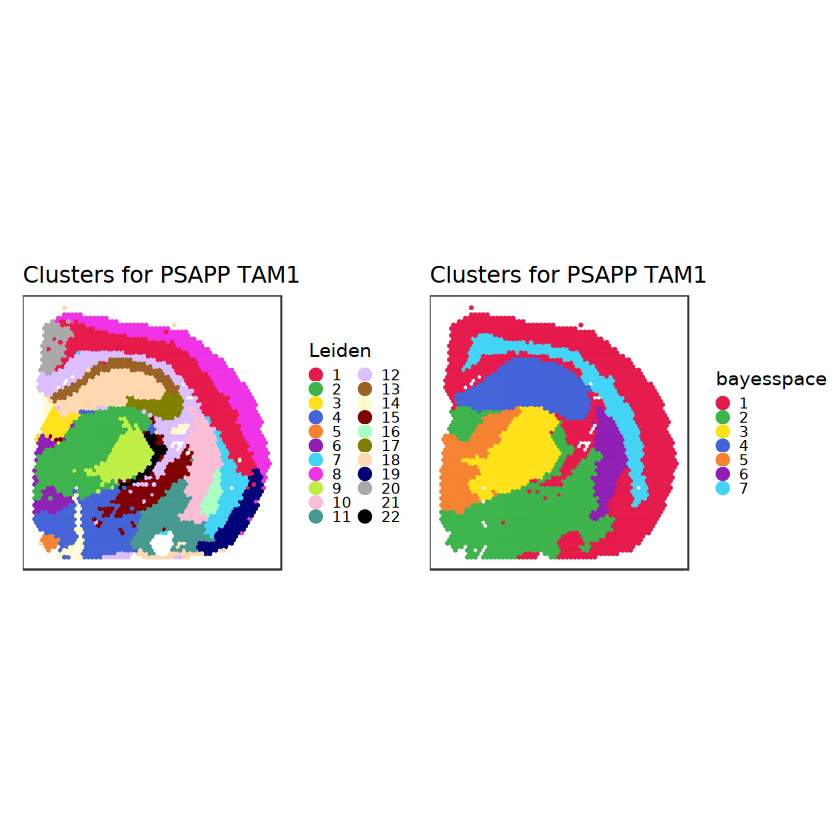

In [112]:
plotSpots(spe, annotate="Leiden") +
plotSpots(spe, annotate="bayesspace") +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Clusters for PSAPP TAM1")

In [113]:
# find marker genes 
mgs <- findMarkers(spe, groups=spe$bayesspace, direction="up")
top <- lapply(mgs, \(df) rownames(df)[df$Top <= 3])
length(top <- unique(unlist(top)))

[1] 56

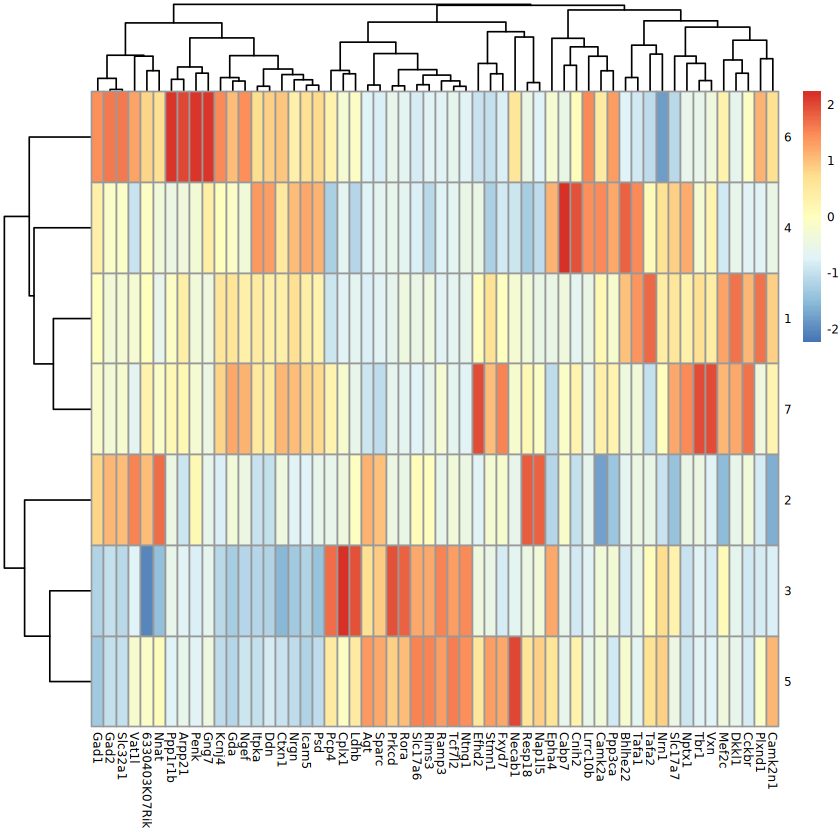

In [114]:
# plot heatmap of top marker genes per cluster
pbs <- aggregateAcrossCells(spe,  
    ids=spe$bayesspace, subset.row=top, 
    use.assay.type="logcounts", statistics="mean")
# use symbols as feature names
mtx <- t(assay(pbs))
colnames(mtx) <- rowData(pbs)$symbol
pheatmap(mat=mtx, scale="column", fontsize = 7)

In [53]:
# save mtx as csv
write.csv(mtx, file="../data/top_genes_TAM1.csv", row.names=TRUE)

#### Annotation 

In [115]:
# assign cell types to clusters
spe$celltype <- NA
spe$celltype[spe$bayesspace == "1"] <- "Excitatory neurons"                
spe$celltype[spe$bayesspace == "2"] <- "Astrocytes"               
spe$celltype[spe$bayesspace == "3"] <- "Inhibitory interneurons"
spe$celltype[spe$bayesspace == "4"] <- "Glutamatergic projection neurons"                   
spe$celltype[spe$bayesspace == "5"] <- "Oligodendrocytes" 
spe$celltype[spe$bayesspace == "6"] <- "Medium spiny neurons"                 
spe$celltype[spe$bayesspace == "7"] <- "Layer-specific excitatory neurons" 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


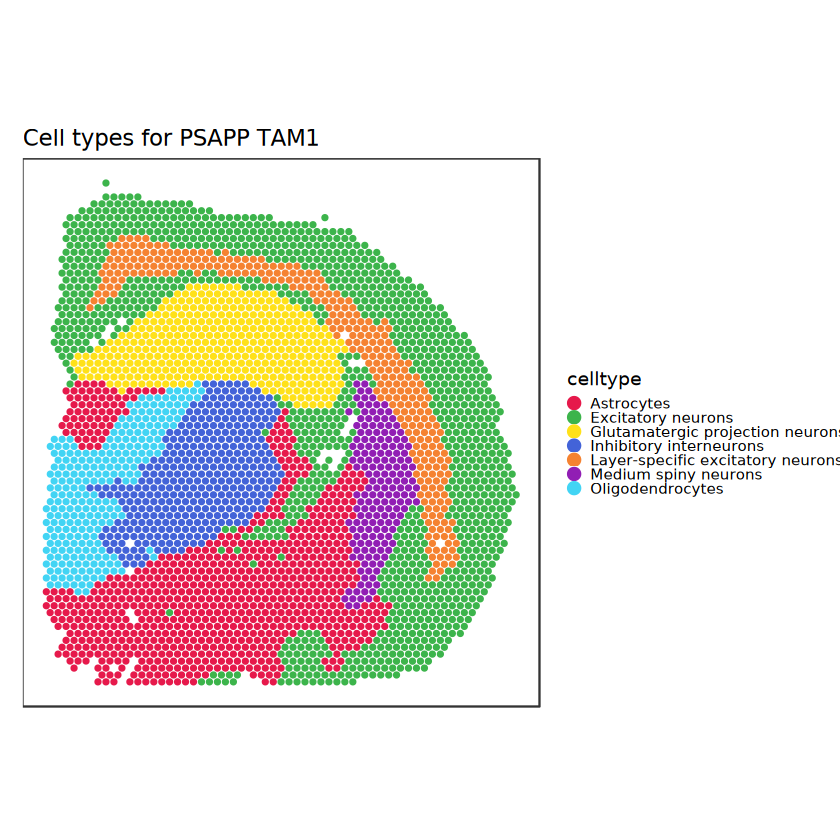

In [116]:
plot_cell_type <- plotSpots(spe, annotate="celltype", point_size=1) +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Cell types for PSAPP TAM1")
plot_cell_type
ggsave("cell_types_plot_PSAPP_TAM1.png", plot=plot_cell_type, width=10, height=8, dpi=300)

#### Signatures

In [117]:
# retrieve hallmark gene sets from 'MSigDB'
db <- msigdbr(species="Mus musculus", collection="H")
# get list of gene symbols, one element per set
gs <- split(db$ensembl_gene, db$gs_name)
# simplify set identifiers (drop prefix, use lower case)
names(gs) <- tolower(gsub("HALLMARK_", "", names(gs)))
# how many sets?
length(gs)

[1] 50

In [118]:
# run AUCell for signature scoring

# realize (sparse) gene expression matrix
mtx <- as(logcounts(spe), "dgCMatrix") 
# use ensembl identifiers as feature names
rownames(mtx) <- rowData(spe)$ensembl_id
# build per-spot gene rankings
rnk <- AUCell_buildRankings(mtx, BPPARAM=bp, plotStats=FALSE, verbose=FALSE)
# calculate AUC for each gene set in each spot
auc <- AUCell_calcAUC(geneSets=gs, rankings=rnk, nCores=th, verbose=FALSE)
# add results as spot metadata
colData(spe)[rownames(auc)] <- res <- t(assay(auc)) 

In [119]:
# take top sets
var <- colVars(res)
top <- names(tail(sort(var), 8))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


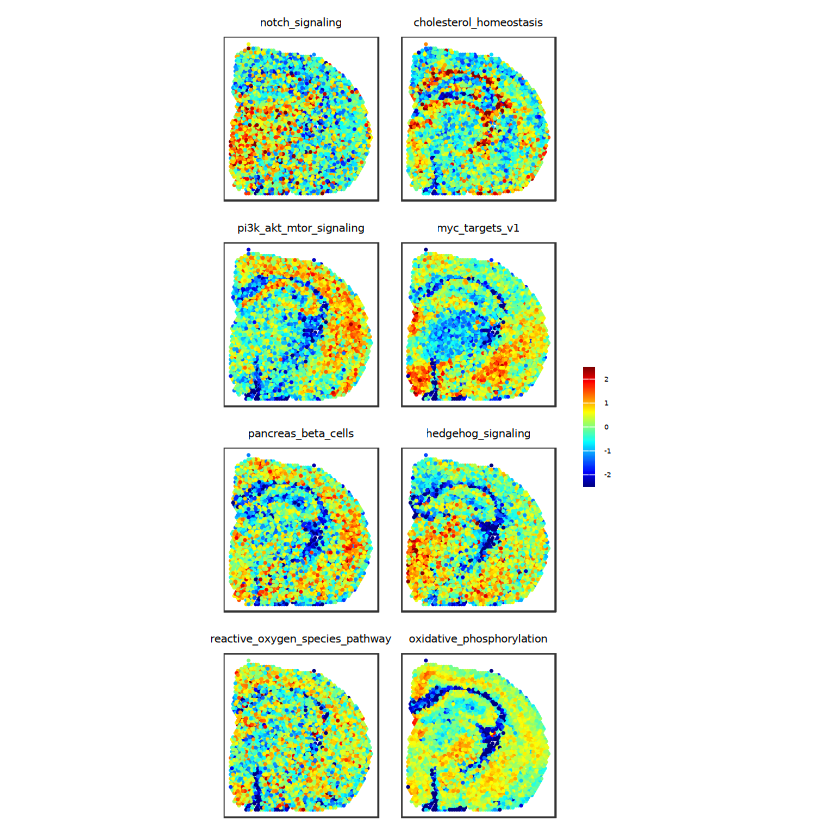

In [120]:
p <- lapply(top, \(.) {
    spe[[.]] <- scale(spe[[.]]) # scaling
    plotSpots(spe, annotate=., point_size = 0.05) # plotting
}) |> 
    # arrange & prettify
    wrap_plots(ncol=2, guides="collect") & 
    scale_color_gradientn(
        colors=pals::jet(),
        oob=scales::squish, 
        limits=c(-2.5, 2.5)) & 
    theme(
        text = element_text(size = 5),
        legend.key.width=unit(0.5, "lines"), 
        legend.key.height=unit(1, "lines")) 
p
ggsave("signature_analysis_plot_PSAPP_TAM1.png", plot=p, width=10, height=8, dpi=300)

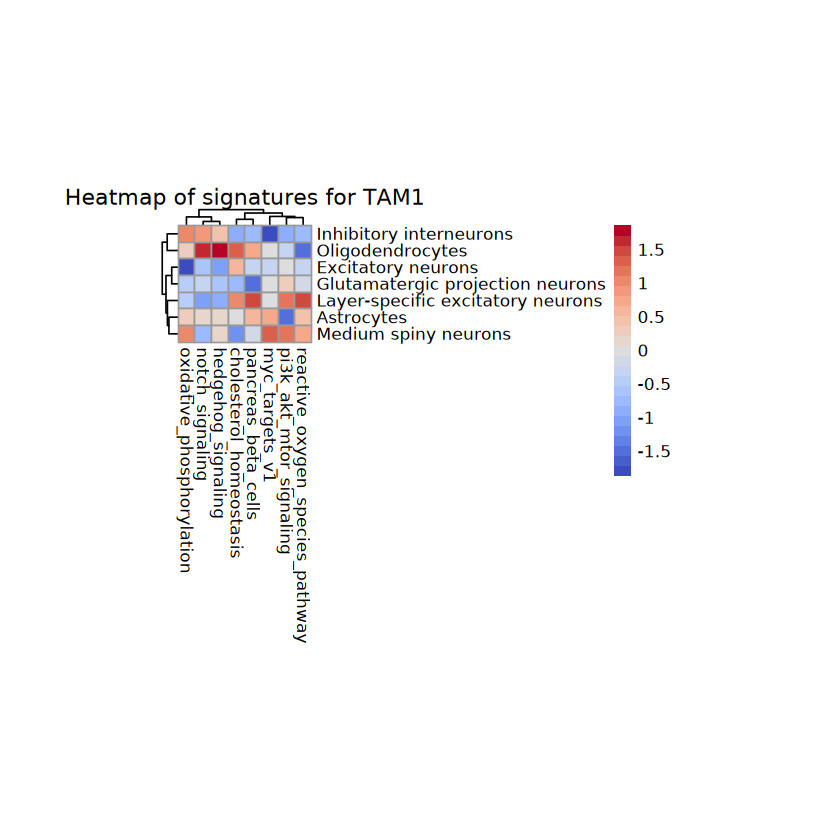

In [121]:
for (. in c("celltype")) {
    # aggregate AUC values by cluster
    mu <- aggregateAcrossCells(auc[top, ], spe[[.]], 
        use.assay.type="AUC", statistics="mean")
    # visualize as (cluster x set) heatmap
    pheatmap(
        mat=t(assay(mu)), scale="column", col=pals::coolwarm(), 
        main=paste("Heatmap of signatures for TAM1"),
        cellwidth=10, cellheight=10, treeheight_row=5, treeheight_col=5)
}

### PSAPP TAM2

In [122]:
spe <- readRDS("../data/ST_GSM6171789_PSAPP_TAM2.rds")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


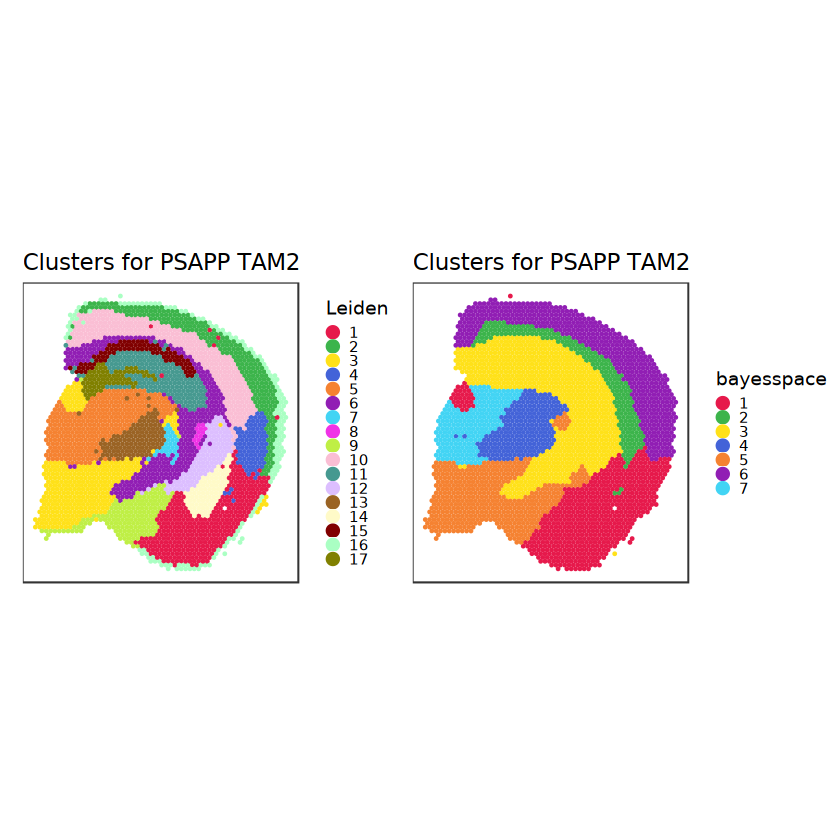

In [123]:
plotSpots(spe, annotate="Leiden") +
plotSpots(spe, annotate="bayesspace") +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Clusters for PSAPP TAM2")

In [124]:
# find marker genes 
mgs <- findMarkers(spe, groups=spe$bayesspace, direction="up")
top <- lapply(mgs, \(df) rownames(df)[df$Top <= 3])
length(top <- unique(unlist(top)))

[1] 70

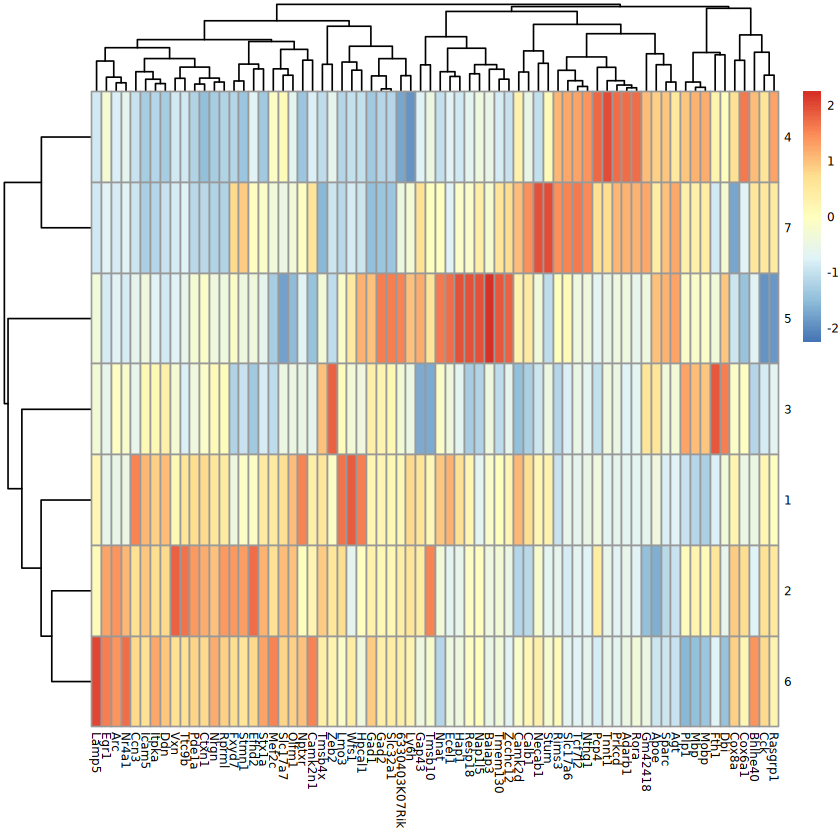

In [125]:
# plot heatmap of top marker genes per cluster
pbs <- aggregateAcrossCells(spe,  
    ids=spe$bayesspace, subset.row=top, 
    use.assay.type="logcounts", statistics="mean")
# use symbols as feature names
mtx <- t(assay(pbs))
colnames(mtx) <- rowData(pbs)$symbol
pheatmap(mat=mtx, scale="column", fontsize = 7)

In [63]:
# save mtx as csv
write.csv(mtx, file="../data/top_genes_TAM2.csv", row.names=TRUE)

#### Annotation 

In [126]:
# assign cell types to clusters
spe$celltype <- NA
spe$celltype[spe$bayesspace == "1"] <- "Excitatory cortical neurons"                
spe$celltype[spe$bayesspace == "2"] <- "Excitatory neurons"               
spe$celltype[spe$bayesspace == "3"] <- "Oligodendrocytes"
spe$celltype[spe$bayesspace == "4"] <- "Interneurons/inhibitory neurons"                   
spe$celltype[spe$bayesspace == "5"] <- "Astrocytes" 
spe$celltype[spe$bayesspace == "6"] <- "Excitatory projection neurons"                 
spe$celltype[spe$bayesspace == "7"] <- "Mixed inhibitory neurons/OPCs" 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


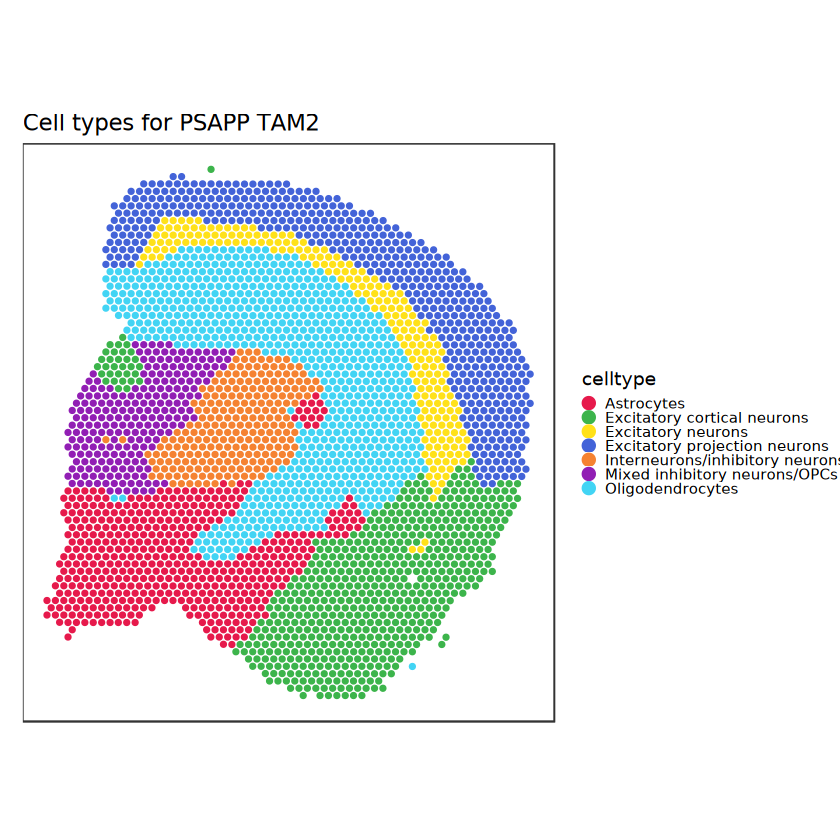

In [127]:
plot_cell_type <- plotSpots(spe, annotate="celltype", point_size=1) +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Cell types for PSAPP TAM2")
plot_cell_type
ggsave("cell_types_plot_PSAPP_TAM2.png", plot=plot_cell_type, width=10, height=8, dpi=300)

#### Signatures

In [ ]:
# retrieve hallmark gene sets from 'MSigDB'
db <- msigdbr(species="Mus musculus", collection="H")
# get list of gene symbols, one element per set
gs <- split(db$ensembl_gene, db$gs_name)
# simplify set identifiers (drop prefix, use lower case)
names(gs) <- tolower(gsub("HALLMARK_", "", names(gs)))
# how many sets?
length(gs)

[1] 50

In [128]:
# run AUCell for signature scoring

# realize (sparse) gene expression matrix
mtx <- as(logcounts(spe), "dgCMatrix") 
# use ensembl identifiers as feature names
rownames(mtx) <- rowData(spe)$ensembl_id
# build per-spot gene rankings
rnk <- AUCell_buildRankings(mtx, BPPARAM=bp, plotStats=FALSE, verbose=FALSE)
# calculate AUC for each gene set in each spot
auc <- AUCell_calcAUC(geneSets=gs, rankings=rnk, nCores=th, verbose=FALSE)
# add results as spot metadata
colData(spe)[rownames(auc)] <- res <- t(assay(auc)) 

In [129]:
# take top sets
var <- colVars(res)
top <- names(tail(sort(var), 8))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


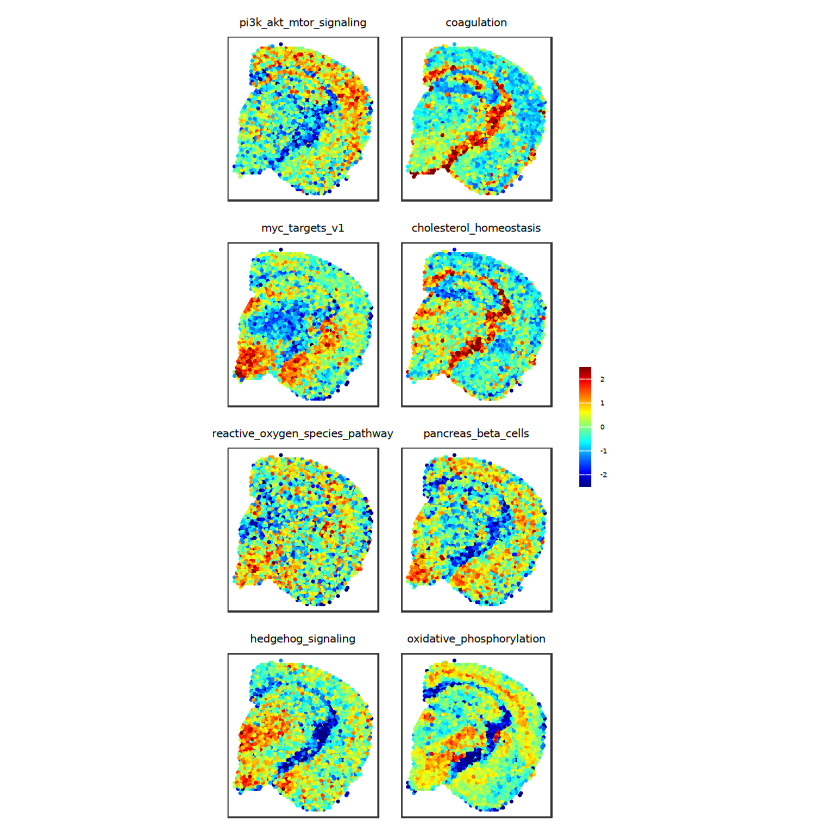

In [130]:
p <- lapply(top, \(.) {
    spe[[.]] <- scale(spe[[.]]) # scaling
    plotSpots(spe, annotate=., point_size = 0.05) # plotting
}) |> 
    # arrange & prettify
    wrap_plots(ncol=2, guides="collect") & 
    scale_color_gradientn(
        colors=pals::jet(),
        oob=scales::squish, 
        limits=c(-2.5, 2.5)) & 
    theme(
        text = element_text(size = 5),
        legend.key.width=unit(0.5, "lines"), 
        legend.key.height=unit(1, "lines")) 
p
ggsave("signature_analysis_plot_PSAPP_TAM2.png", plot=p, width=10, height=8, dpi=300)

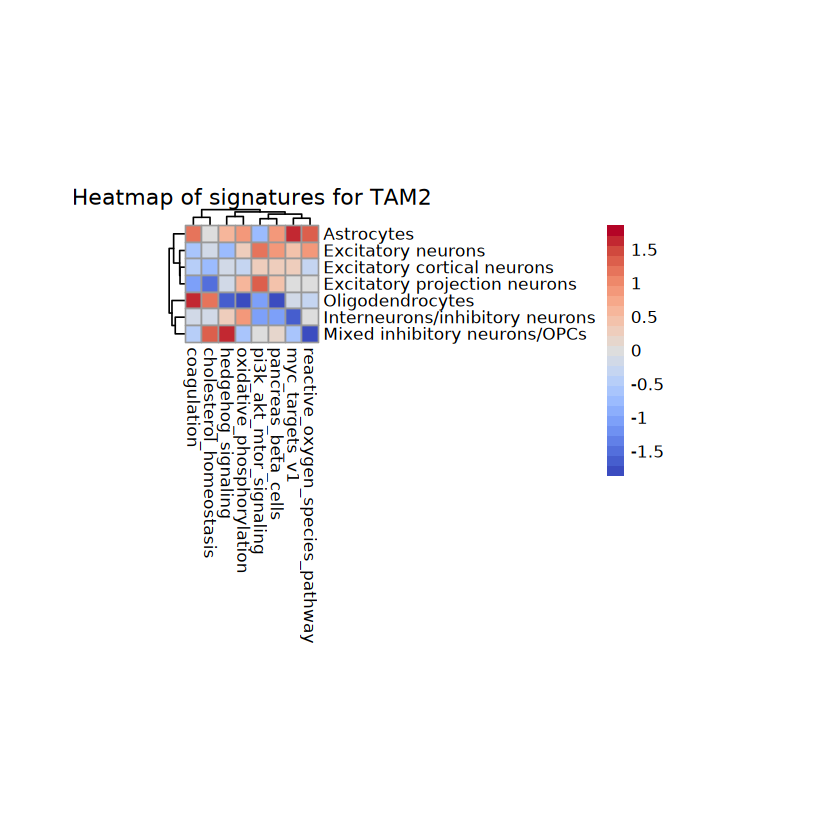

In [131]:
for (. in c("celltype")) {
    # aggregate AUC values by cluster
    mu <- aggregateAcrossCells(auc[top, ], spe[[.]], 
        use.assay.type="AUC", statistics="mean")
    # visualize as (cluster x set) heatmap
    pheatmap(
        mat=t(assay(mu)), scale="column", col=pals::coolwarm(), 
        main=paste("Heatmap of signatures for TAM2"),
        cellwidth=10, cellheight=10, treeheight_row=5, treeheight_col=5)
}

### PSAPP TAM3

In [132]:
spe <- readRDS("../data/ST_GSM6171793_PSAPP_TAM3.rds")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


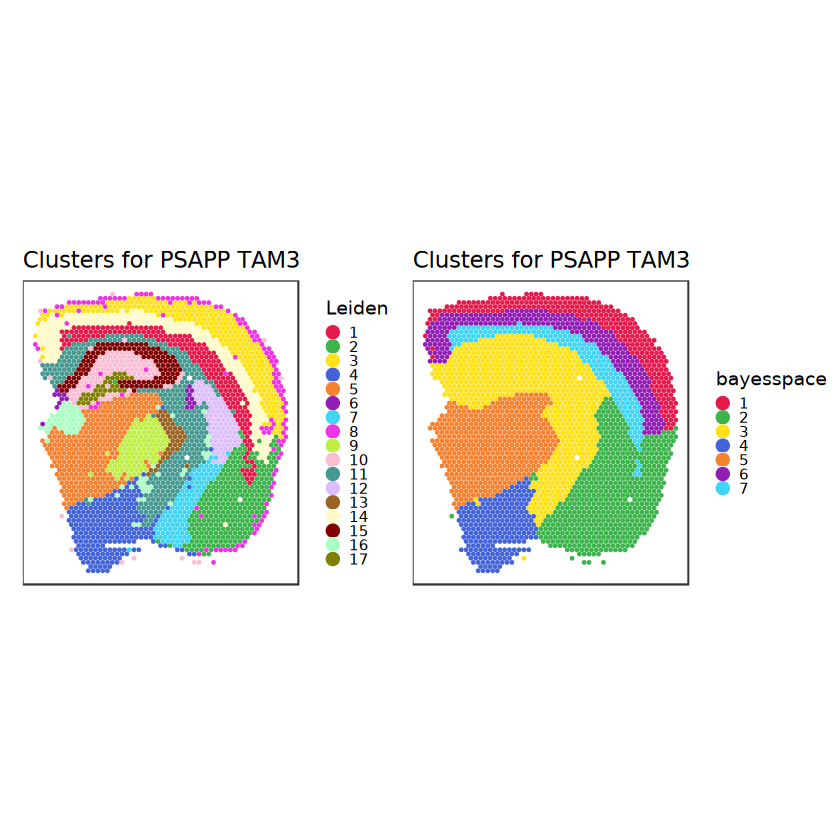

In [133]:
plotSpots(spe, annotate="Leiden") +
plotSpots(spe, annotate="bayesspace") +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Clusters for PSAPP TAM3")

In [134]:
# find marker genes 
mgs <- findMarkers(spe, groups=spe$bayesspace, direction="up")
top <- lapply(mgs, \(df) rownames(df)[df$Top <= 3])
length(top <- unique(unlist(top)))

[1] 59

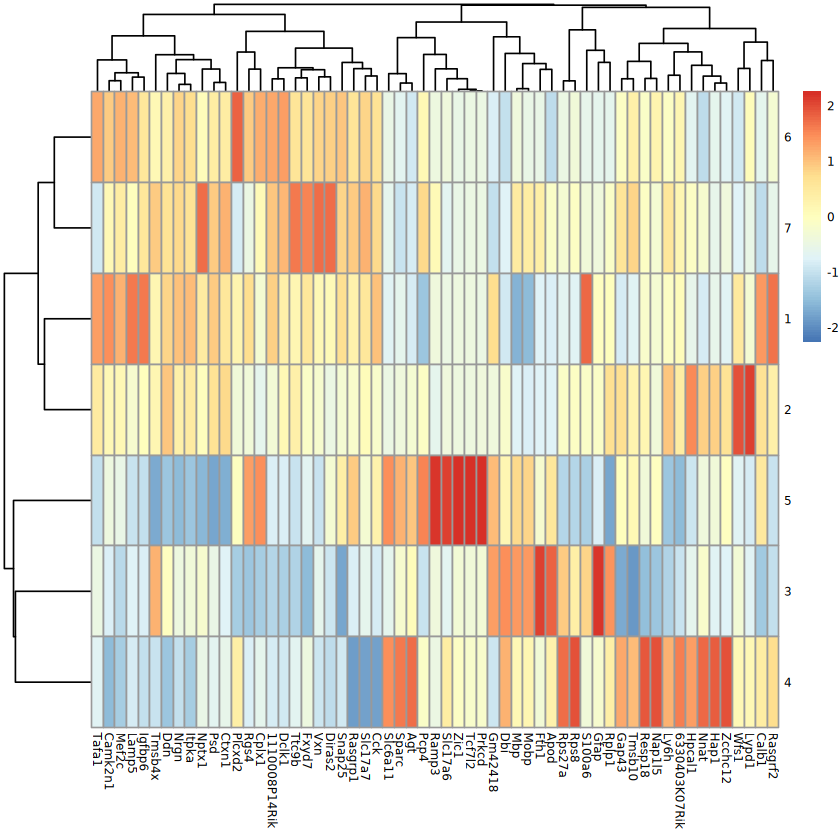

In [135]:
# plot heatmap of top marker genes per cluster
pbs <- aggregateAcrossCells(spe,  
    ids=spe$bayesspace, subset.row=top, 
    use.assay.type="logcounts", statistics="mean")
# use symbols as feature names
mtx <- t(assay(pbs))
colnames(mtx) <- rowData(pbs)$symbol
pheatmap(mat=mtx, scale="column", fontsize = 7)

In [73]:
# save mtx as csv
write.csv(mtx, file="../data/top_genes_TAM3.csv", row.names=TRUE)

#### Annotation 

In [136]:
# assign cell types to clusters
spe$celltype <- NA
spe$celltype[spe$bayesspace == "1"] <- "Inhibitory interneurons"                
spe$celltype[spe$bayesspace == "2"] <- "Excitatory neurons"               
spe$celltype[spe$bayesspace == "3"] <- "Oligodendrocytes"
spe$celltype[spe$bayesspace == "4"] <- "Astrocytes"                   
spe$celltype[spe$bayesspace == "5"] <- "Specialized interneurons" 
spe$celltype[spe$bayesspace == "6"] <- "Upper layer excitatory neurons"                 
spe$celltype[spe$bayesspace == "7"] <- "Deep layer excitatory neurons" 

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


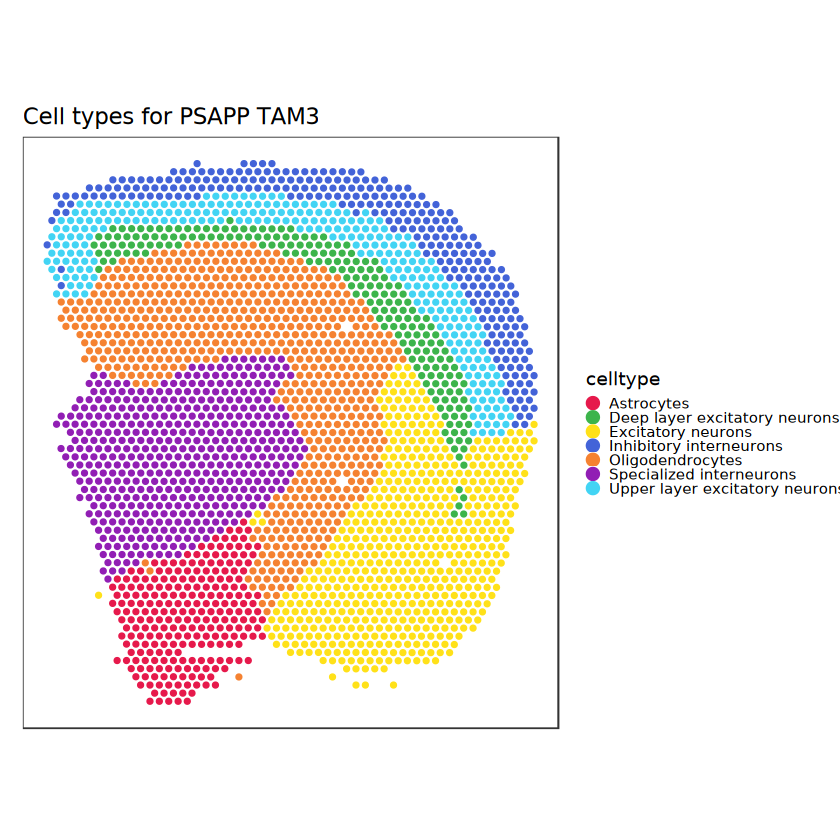

In [137]:
plot_cell_type <- plotSpots(spe, annotate="celltype", point_size=1) +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) & 
    ggtitle("Cell types for PSAPP TAM3")
plot_cell_type
ggsave("cell_types_plot_PSAPP_TAM3.png", plot=plot_cell_type, width=10, height=8, dpi=300)

#### Signatures

In [ ]:
# retrieve hallmark gene sets from 'MSigDB'
db <- msigdbr(species="Mus musculus", collection="H")
# get list of gene symbols, one element per set
gs <- split(db$ensembl_gene, db$gs_name)
# simplify set identifiers (drop prefix, use lower case)
names(gs) <- tolower(gsub("HALLMARK_", "", names(gs)))
# how many sets?
length(gs)

[1] 50

In [138]:
# run AUCell for signature scoring

# realize (sparse) gene expression matrix
mtx <- as(logcounts(spe), "dgCMatrix") 
# use ensembl identifiers as feature names
rownames(mtx) <- rowData(spe)$ensembl_id
# build per-spot gene rankings
rnk <- AUCell_buildRankings(mtx, BPPARAM=bp, plotStats=FALSE, verbose=FALSE)
# calculate AUC for each gene set in each spot
auc <- AUCell_calcAUC(geneSets=gs, rankings=rnk, nCores=th, verbose=FALSE)
# add results as spot metadata
colData(spe)[rownames(auc)] <- res <- t(assay(auc)) 

In [139]:
# take top sets
var <- colVars(res)
top <- names(tail(sort(var), 8))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


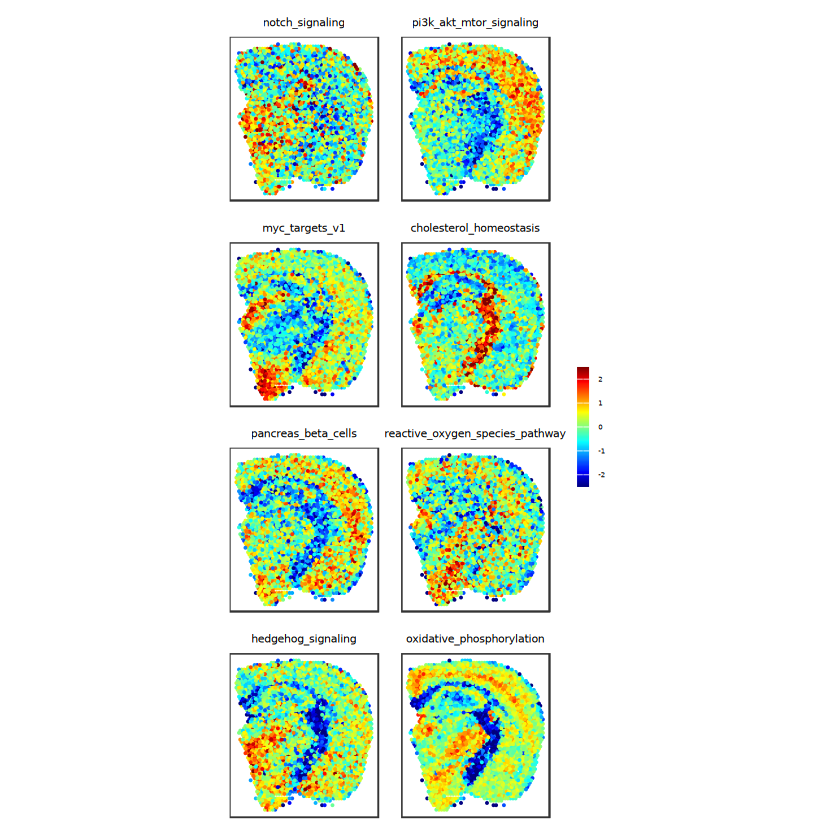

In [140]:
p <- lapply(top, \(.) {
    spe[[.]] <- scale(spe[[.]]) # scaling
    plotSpots(spe, annotate=., point_size = 0.05) # plotting
}) |> 
    # arrange & prettify
    wrap_plots(ncol=2, guides="collect") & 
    scale_color_gradientn(
        colors=pals::jet(),
        oob=scales::squish, 
        limits=c(-2.5, 2.5)) & 
    theme(
        text = element_text(size = 5),
        legend.key.width=unit(0.5, "lines"), 
        legend.key.height=unit(1, "lines")) 
p
ggsave("signature_analysis_plot_PSAPP_TAM3.png", plot=p, width=10, height=8, dpi=300)

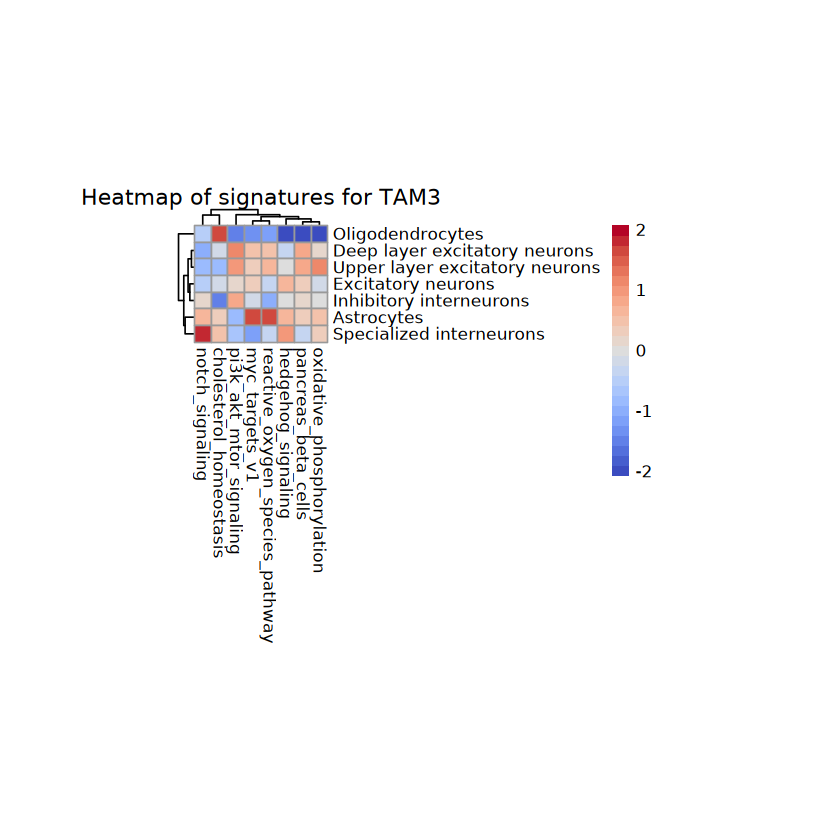

In [141]:
for (. in c("celltype")) {
    # aggregate AUC values by cluster
    mu <- aggregateAcrossCells(auc[top, ], spe[[.]], 
        use.assay.type="AUC", statistics="mean")
    # visualize as (cluster x set) heatmap
    pheatmap(
        mat=t(assay(mu)), scale="column", col=pals::coolwarm(), 
        main=paste("Heatmap of signatures for TAM3"),
        cellwidth=10, cellheight=10, treeheight_row=5, treeheight_col=5)
}